In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
import glob
import sys
from datetime import date
import json

import neuraltoolkit as ntk
from samb_work import dimtools as dimt

from ripple_detection import Karlsson_ripple_detector, Kay_ripple_detector
from ripple_detection.simulate import simulate_time

from scipy.stats import ranksums

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

if sys.platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'
    
pth = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/figure_4/'

In [3]:
#                        Colors

with open(f'/{basedir}/HlabShare/appps1_cortical_communication_samb/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)

dump = 1

In [4]:
def get_riptimes(ripcsv, peakdist = 0.1, ampthresh = 50):
    riptimes = pd.read_csv(ripcsv)
    fivemin = 60*5
    ripplecounts = riptimes['file'].value_counts().sort_index()
    sec_elapsed = np.arange(len(ripplecounts)) * fivemin
    secelapdic = {ripplecounts.index.values[i]: sec_elapsed[i] for i in range(len(ripplecounts))}
    riptimes['sec_elapsed'] = riptimes['file'].map(secelapdic)
    riptimes = riptimes.sort_values(['file','start_time'])
    riptimes['start_time'] = riptimes['start_time'] + riptimes['sec_elapsed']
    riptimes['end_time'] = riptimes['end_time'] + riptimes['sec_elapsed']
    riptimes['peak_time'] = riptimes['start_time'] + (riptimes['length']/2)
    riptimes['ripple_number'] = np.arange(len(riptimes)) + 1
    #require that peaks be peakdist sec apart
    diff_bw_peaks = np.pad(np.diff(riptimes.peak_time),(1,0))
    riptimes = riptimes[diff_bw_peaks > peakdist]
    #amplitude criteria
    riptimes = riptimes[riptimes['amplitude']>ampthresh]
    return(riptimes)

def get_sleeptimes(sleepnpy):
    #deal with sleepybois
    sleep_states = np.zeros((2,0))
    sleeps = np.load(sleepnpy)
    timestamps = (np.nonzero(np.diff(sleeps))[0]+1)*4
    time_ind = (timestamps/4)-1
    states = sleeps[time_ind.astype(int)]
    s = np.array(states)
    t = np.stack((timestamps,s))
    sleep_states = np.concatenate((sleep_states,t), axis =1)
    start_time = np.append([0],sleep_states[0,:-1])
    stop_time = sleep_states[0,:]
    sleepstate = sleep_states[1,:]
    sleepdf = pd.DataFrame({'start_time': start_time,'stop_time': stop_time,'sleepstate': sleepstate})
    return(sleepdf)

def riptimes_by_state(riptimes,sleepdf,state_of_interest):
    if state_of_interest == 'active':
        stateid = 1
    elif state_of_interest == 'nrem':
        stateid = 2
    elif state_of_interest == 'rem':
        stateid = 3
    elif state_of_interest == 'quiet':
        stateid = 5
    else:
        print(f'State "{state_of_interest}" not recognized')
    statestart = sleepdf[sleepdf.sleepstate==stateid].start_time
    statestop = sleepdf[sleepdf.sleepstate==stateid].stop_time
    rdfstatelist = [riptimes[(riptimes.peak_time>start) & (riptimes.peak_time < stop)] for start,stop in zip(statestart.values,statestop.values)]
    rdf_state = pd.concat(rdfstatelist)
    return(rdf_state)

def bin_and_align_spikes(neurons,eventtimes,binsize,windowsize):
    binned = np.zeros([len(neurons),int((windowsize*2)/binsize),len(eventtimes)])
    for e,event in enumerate(eventtimes):
        lbound = event - windowsize
        rbound = event + windowsize
        for c,cell in enumerate(neurons):
            spiketimes = cell.spike_time_sec
            spks = spiketimes[(spiketimes>lbound)&(spiketimes<rbound)]
            binned[c,:,e] = dimt.bin_spikes_1d(spks-lbound,binsize,windowsize*2)
    return(binned)

def z_score(binned, baseline_length = 20):
    binbl = np.hstack([binned[:,:baseline_length],binned[:,-baseline_length:]])
    binmean = np.mean(binbl,axis=1)
    binstd = np.std(binbl,axis=1)
    binnum = binned - np.reshape(binmean,[np.shape(binmean)[0],1])
    bin_z = binnum/np.reshape(binstd,[np.shape(binstd)[0],1])
    return(bin_z)

def get_peth_data(rippledir,wtlist,applist,state,region,celltype):
    
    wt_files = []
    for ani in wtlist:
        wt_files.append(glob.glob(f'{rippledir}*{ani}*{state.lower()}*{region.lower()}_{celltype.lower()}*mean.npy'))
    wt_files = [item for sublist in wt_files for item in sublist]
    wtdat = np.zeros([2,2000])
    for fil in wt_files:
        fildat = np.load(fil)
        wtdat = np.vstack([wtdat,fildat])
    wtdat = wtdat[2:,:]

    app_files = []
    for ani in applist:
        app_files.append(glob.glob(f'{rippledir}*{ani}*{state.lower()}*{region.lower()}_{celltype.lower()}*mean.npy'))
    app_files = [item for sublist in app_files for item in sublist]
    appdat = np.zeros([2,2000])
    for fil in app_files:
        fildat = np.load(fil)
        appdat = np.vstack([appdat,fildat])
    appdat = appdat[2:,:]
    
    return(wtdat,appdat)

def zscore_baseline(peth_mean,binsz):
    numer = np.subtract(peth_mean.T,np.mean(peth_mean[:,:int(0.3/binsz)],axis=1)).T
    denom = np.std(peth_mean[:,:int(0.3/binsz)],axis=1).reshape([peth_mean.shape[0],1])
    peth_rsu_mean_zs = numer/denom
    midrange = (int(peth_mean.shape[1]/2 - peth_mean.shape[1]/40),int(peth_mean.shape[1]/2 + peth_mean.shape[1]/40))
    peth_rsu_mean_zs = peth_rsu_mean_zs[np.argsort(-np.max(peth_rsu_mean_zs[:,midrange[0]:midrange[1]],axis=1)),:]
    # plt.imshow(peth_rsu_mean_zs)
    # # plt.xlim(750,1250)
    # plt.show()
    return(peth_rsu_mean_zs)

def make_plots(wtdat,appdat,title,savefig=False,savedir=''):
#     binsize = 0.001
    x = (np.arange(np.shape(wtdat)[1]) - (np.shape(wtdat)[1]/2))
    
    stdev_wt = np.std(wtdat,axis=0)/4
    stdev_app = np.std(appdat,axis=0)/4
    
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
    ax[0].plot(x,np.mean(wtdat,axis=0),c='blue',alpha=0.5,label='WT')
    ax[0].plot(x,np.mean(appdat,axis=0),c='red',alpha=0.5,label='APP')
    ax[0].fill_between(x,np.mean(wtdat,axis=0) - stdev_wt, np.mean(wtdat,axis=0) + stdev_wt,
    color=geno_clrs['WT'],alpha=0.1)
    ax[0].fill_between(x,np.mean(appdat,axis=0) - stdev_app, np.mean(appdat,axis=0) + stdev_app,
    color=geno_clrs['APP'],alpha=0.1)
    ax[0].set_xlabel('Time from Ripple Peak (ms)',fontsize=14)
    ax[0].set_ylabel('Z Score Count',fontsize=14)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].legend(fontsize=14)
    ax[0].set_title(title,fontsize=16)
    
    ax[1].plot(x,np.mean(wtdat,axis=0),c='blue',alpha=0.5,label='WT')
    ax[1].plot(x,np.mean(appdat,axis=0),c='red',alpha=0.5,label='APP')
    ax[1].fill_between(x,np.mean(wtdat,axis=0) - stdev_wt, np.mean(wtdat,axis=0) + stdev_wt,
    color=geno_clrs['WT'],alpha=0.1)
    ax[1].fill_between(x,np.mean(appdat,axis=0) - stdev_app, np.mean(appdat,axis=0) + stdev_app,
    color=geno_clrs['APP'],alpha=0.1)
    ax[1].set_xlabel('Time from Ripple Peak (ms)',fontsize=14)
    ax[1].set_ylabel('Z scored Firing Rate',fontsize=14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].legend(fontsize=14)
    ax[1].set_xlim(-300,300)
    ax[1].set_title(title,fontsize=16)
    if savefig == True:
        plt.savefig(savedir+title.lower().replace(' ','_') + '.pdf',bbox_inches='tight')
    plt.show()

    fig,ax = plt.subplots(figsize=(10,20))
    ax.imshow(np.vstack([wtdat[:10,:],appdat[:10,:]]))
    ax.set_xlim(925,1075)
    ax.set_ylabel('Cell',fontsize=14)
    ax.set_xlabel('Time from Ripple Peak (ms)',fontsize=14)
    ax.set_xticks(np.arange(925,1076,25))
    ax.set_xticklabels(np.arange(925,1076,25) - 1000,fontsize=12)
    ax.set_yticks(np.arange(0,20,5))
    ax.set_yticklabels(np.hstack([np.arange(0,10,5),np.arange(0,10,5)]),fontsize=12)
    if savefig == True:
        plt.savefig(savedir+title.lower().replace(' ','_') + '_selectcells.pdf',bbox_inches='tight')
    plt.show()
    
def calc_isi(cell):
    time_s = cell.spike_time/cell.fs
    start = cell.start_time
    end = cell.end_time
    idx = np.where(np.logical_and(time_s >= start, time_s <= end))[0]
    ISI = np.diff(time_s[idx])

    # plot histogram and calculate contamination
    edges = np.linspace(0, 0.1, 51)
    hist_isi = np.histogram(ISI, edges)

    # Calculate contamination percentage
    contamination = 100*(sum(hist_isi[0][0:int((0.1/0.1) *
                         (101-1)/50)])/sum(hist_isi[0]))
    contamination = round(contamination, 2)
    return(contamination)

In [4]:
#Load downsampled data
rawca1 = np.load(f'/{basedir}/HlabShare/Sleep_Scoring/CAF00077/02022021_videos_lfp/rawdat_ds/2021-02-03_02-28-25_ca1_raw.npy')

SAMPLING_FREQUENCY = 1500
nsec = 5*60
n_samples = int(SAMPLING_FREQUENCY * nsec)

# spikes_ca1 = f'/{basedir}/HlabShare/SamB/APPdata/APP_dataset/CAF77/0202/12_24/CAF77_0202_12_24_singleunits.npy'
spikes_ca1 = f'/{basedir}/HlabShare/Clustering_Data/CAF00077/02022021/12_24/probe1/co/low_yield/H_2021-02-03_02-28-25_2021-02-03_14-18-25_neurons_group0.npy'
nlist = np.load(spikes_ca1, allow_pickle='True')
nrns_ca1 = dimt.nrnlist_by_region(nlist,'CA1')

In [5]:
#Simulate time
simtime = simulate_time(n_samples, SAMPLING_FREQUENCY)
speed = np.ones_like(simtime)

In [6]:
#Find ripples
filtered_rip = ntk.butter_bandpass(rawca1, 150, 250, SAMPLING_FREQUENCY, order = 3)
filtered_rip = filtered_rip.T
# ripple_times = Kay_ripple_detector(simtime, filtered_rip, speed, SAMPLING_FREQUENCY)
ripple_times = Karlsson_ripple_detector(simtime, filtered_rip, speed, SAMPLING_FREQUENCY)

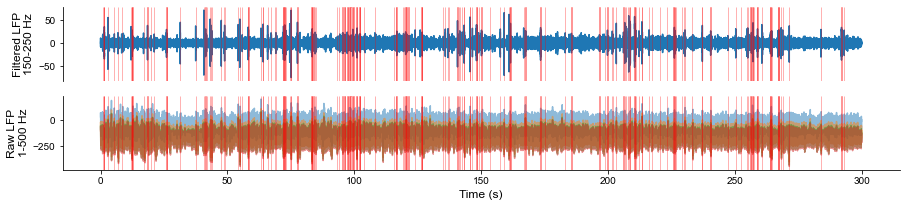

In [7]:
#Plot ripples across entire 5 minutes
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 3), sharex=True)
ax[0].plot(simtime, np.mean(filtered_rip[:,:4],axis=1))
ax[1].plot(simtime, rawca1.T[:,:4],alpha=0.5)
# ax[1].plot(simtime, np.mean(rawca1.T,axis=1))
for ripple in ripple_times.itertuples():
    ax[0].axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=10)
    ax[1].axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='red', zorder=10)
    
ax[0].set_ylabel('Filtered LFP\n150-250 Hz',fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].xaxis.set_visible(False)
ax[1].set_ylabel('Raw LFP\n1-500 Hz',fontsize=12)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Time (s)',fontsize=12)

if dump:
    filename = 'ripples_highlighted.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [8]:
#filter lFP 1 to 500Hz
rawca1_bp = ntk.butter_bandpass(rawca1, 1, 500, SAMPLING_FREQUENCY, order = 3)

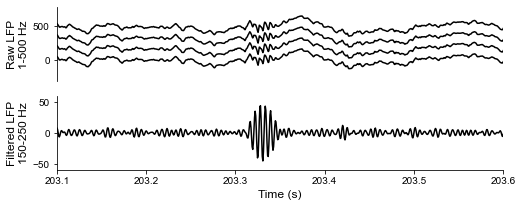

In [9]:
#Single ripple plot

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(8, 3), sharex=True)
ax[0].plot(simtime, rawca1_bp.T[:,:4] + np.tile(np.arange(0,654,(654/4)),450000).reshape(450000,4),color='black')
ax[1].plot(simtime, np.mean(filtered_rip[:,:4],axis=1),color='black')

plt.xlim(203.1,203.6)
# ax[0].set_ylim(-350,300)
ax[1].set_ylim(-60,60)

ax[0].set_ylabel('Raw LFP\n1-500 Hz',fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].xaxis.set_visible(False)
ax[1].set_ylabel('Filtered LFP\n150-250 Hz',fontsize=12)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Time (s)',fontsize=12)

if dump:
    filename = '_ripple_example.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

/Users/khengen/opt/anaconda3/envs/newschool/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


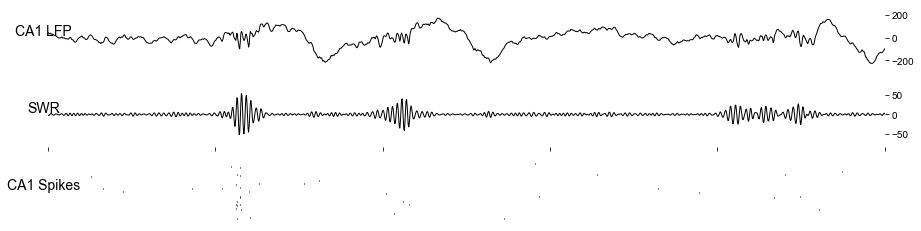

In [10]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 4), sharex=True)

ax[0].plot(simtime, np.mean(rawca1_bp.T[:,:4],axis=1),color='black',linewidth=1)
ax[0].set_ylabel('CA1 LFP',rotation=0,fontsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].yaxis.tick_right()
ax[0].xaxis.set_visible(False)

ax[1].plot(simtime, np.mean(filtered_rip[:,:4],axis=1),color='black',linewidth=1)
ax[1].set_ylabel('SWR',rotation=0,fontsize=14)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].yaxis.tick_right()
# ax[1].xaxis.set_visible(False)

starttime = 43
endtime = 44
cellstoplot = nrns_ca1
spike_timestamps = []
for cellnum in np.arange(len(cellstoplot)):
    index = (cellstoplot[cellnum].spike_time_sec>starttime)&(cellstoplot[cellnum].spike_time_sec<endtime)
    spikes = cellstoplot[cellnum].spike_time_sec[index]
    spike_timestamps.append(spikes)
spikeraster = np.asarray(spike_timestamps)

colors2 = [[0, 0, 0]]
# ax[2].eventplot(spikeraster[-7:],colors=colors2,lineoffsets=1,linelengths=0.5,linewidths=1)
ax[2].eventplot(spikeraster,colors=colors2,lineoffsets=1,linelengths=0.5,linewidths=1)

ax[2].set_ylabel('CA1 Spikes',rotation=0,fontsize=14)
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].xaxis.set_visible(False)

# ax[2].plot(vel_xy_scaled)
# plt.xlim(40,50)
plt.xlim(43,44)
# plt.xlim(71.5,75.5)

if dump:
    filename = 'ripple_and_lfp_tseries.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [11]:
dirlist = glob.glob(f'/{basedir}/HlabShare/SamB/APPdata/APP_dataset/*/*/*/')
wt = ['CAF69','CAF77','CAF81','CAF82']
app = ['CAF71','CAF73','CAF74','CAF75']

In [12]:
genos = []
animals = []
states = []
epochnames = []
nrips = []
ripdens = []
lenmeans = []
lenstds = []
ampmeans = []
ampstds = []

for epochdir in dirlist:
    epochname = epochdir.split('APP_dataset/')[-1].replace('_','-').replace('/','_')[:-1]
    animal = epochname.split('_')[0]
    if animal in wt:
        geno='wt'
    elif animal in app:
        geno='app'
        
    ripplebois = glob.glob(epochdir + '*ripple_times*.csv')[0]
    sleepybois = glob.glob(epochdir + '*sleep.npy')[0]
    riptimes = get_riptimes(ripplebois)
    sleepdf = get_sleeptimes(sleepybois)

    sleepstates = ['nrem','active','rem']

    for state in sleepstates:

        riptimes_state = riptimes_by_state(riptimes,sleepdf,state)
        n_rips = len(riptimes_state)
        if n_rips > 0:
            reclen = np.round(np.max(riptimes_state.peak_time))
            ripbinned = dimt.bin_spikes_1d(riptimes_state.peak_time,binsize=60,tspan= reclen)
            rip_dens = np.mean(ripbinned[ripbinned>0])

            genos.append(geno)
            animals.append(animal)
            states.append(state)
            epochnames.append(epochname)
            nrips.append(n_rips)
            ripdens.append(rip_dens)
            lenmeans.append(np.mean(riptimes_state.length) * 1000)
            lenstds.append(np.std(riptimes_state.length))
            ampmeans.append(np.mean(riptimes_state.amplitude))
            ampstds.append(np.std(riptimes_state.amplitude))

ripdf = pd.DataFrame({'geno': genos, 'animal': animals, 'state': states, 'epoch': epochnames,'n_ripples': nrips,
                     'density': ripdens, 'duration': lenmeans, 'amplitude': ampmeans})

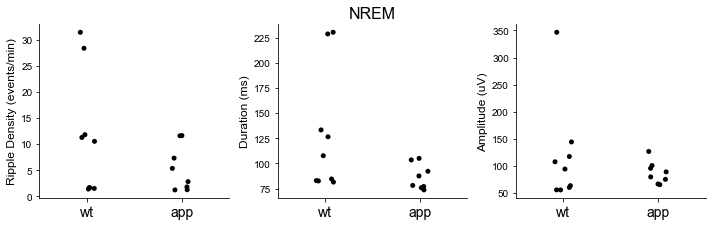

In [13]:
# for sleepstate in ['nrem','active','rem']:
    
sleepstate = 'nrem'

# ripdf_agg = ripdf[ripdf.state==sleepstate].groupby(['animal','geno']).aggregate('mean').reset_index()
ripdf_agg = ripdf[ripdf.state==sleepstate]


fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(10,3))

sns.stripplot(ax = ax[0], x="geno", y="density", data=ripdf_agg,
              color='black',order=['wt','app'])
ax[0].set_ylabel('Ripple Density (events/min)',fontsize=12)

sns.stripplot(ax = ax[1], x="geno", y="duration", data=ripdf_agg,
              color='black',order=['wt','app'])
ax[1].set_ylabel('Duration (ms)',fontsize=12)

sns.stripplot(ax = ax[2], x="geno", y="amplitude", data=ripdf_agg,
             color='black',order=['wt','app'])
ax[2].set_ylabel('Amplitude (uV)',fontsize=12)

for j in range(len(ax)):
    ax[j].set_xlabel('')
    ax[j].tick_params(axis='x', which='major', labelsize=14)

plt.tight_layout()
ax[1].set_title(sleepstate.upper(),fontsize=16)
sns.despine()

if dump:
    filename = f'ripple_stats_{sleepstate}.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()

In [14]:
binsize=0.001
peri_rip_time = 0.5
epochlen = int(2*peri_rip_time/binsize)

epochdir = f'/{basedir}/HlabShare/SamB/APPdata/APP_dataset/CAF71/0103/12_20/'
# savedir = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/G_ripple_figure/plots/'
ripplebois = glob.glob(epochdir + '*ripple_times*.csv')[0]
sleepybois = glob.glob(epochdir + '*sleep.npy')[0]
spikybois = glob.glob(epochdir + '*singleunits.npy')[0]
riptimes = get_riptimes(ripplebois, ampthresh = 50)
sleepdf = get_sleeptimes(sleepybois)
riptimes_state = riptimes_by_state(riptimes,sleepdf,'nrem')
nrn = np.load(spikybois, allow_pickle=True)
nrn_rsc = dimt.nrnlist_by_region(nrn,'RSC')
# nrn_acc = dimt.nrnlist_by_region(nrn,'ACC')
# nrn_v1 = dimt.nrnlist_by_region(nrn,'V1')

### subset ripples
if len(riptimes_state) < 500:
    rip_subset = riptimes_state.sort_values('amplitude')
else:
    rip_subset = riptimes_state.sort_values('amplitude')[-500:]
    
### bin and align data to ripples
bin_rsc = bin_and_align_spikes(nrn_rsc,rip_subset.peak_time.values,binsize,peri_rip_time)

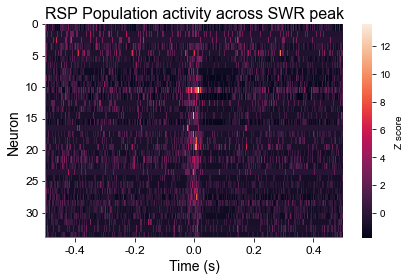

In [15]:
xticklabs = np.round(np.hstack([np.arange(-0.4,0,0.2),
                                np.arange(0,0.41,0.2)]),2)
xtickpos = (xticklabs + peri_rip_time) * 1000
nrips = bin_rsc.shape[2]
ncell = bin_rsc.shape[0]

#plot each neurons' average response across ripples
peth = z_score(np.mean(bin_rsc,axis=2))
sns.heatmap(peth,cbar_kws={'label': 'Z score'})
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Neuron',fontsize=14)
plt.title('RSP Population activity across SWR peak',fontsize=16)

plt.axhline(ncell, color = 'grey',linewidth = 2)
plt.axvline(0, color = 'grey',linewidth = 1)

yticklabs = np.arange(0,ncell,5)
plt.xticks(xtickpos,xticklabs,rotation=0,fontsize=12)
plt.yticks(yticklabs,yticklabs,rotation=0,fontsize=12)
plt.tight_layout()
if dump:
    filename = '_ripple_peth_allnrn.pdf'
    plt.savefig( pth+today+filename)

else:
    pass
plt.show()
# plt.close()
# plt.clf()

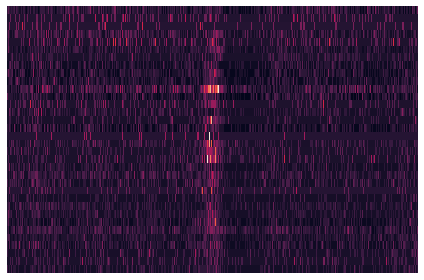

In [16]:
xticklabs = np.round(np.hstack([np.arange(-0.4,0,0.2),
                                np.arange(0,0.41,0.2)]),2)
xtickpos = (xticklabs + peri_rip_time) * 1000
nrips = bin_rsc.shape[2]
ncell = bin_rsc.shape[0]

#plot each neurons' average response across ripples
peth = z_score(np.mean(bin_rsc,axis=2))
sns.heatmap(peth, cbar = False)
plt.xlabel('')
plt.ylabel('')



plt.xticks([])
plt.yticks([])
plt.tight_layout()

if dump:

    filename1 = '_ripple_peth_allnrn.jpg'
    plt.savefig( pth+today+filename1, dpi=600)
else:
    pass
plt.show()
# plt.close()
# plt.clf()

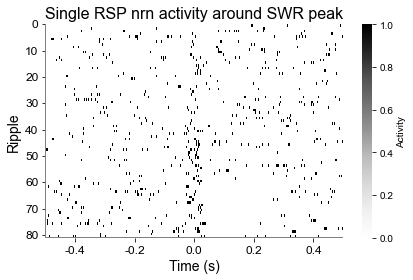

In [17]:
#plot a single neuron (time X ripples)
bestcell = np.argmax(np.max(peth,axis=1))
sns.heatmap(bin_rsc[10,:,:].T,cbar_kws={'label': 'Activity'},cmap="Greys")
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Ripple',fontsize=14)
plt.title(f'Single RSP nrn activity around SWR peak',fontsize=16)

plt.axhline(nrips, color = 'grey',linewidth = 2)
plt.axvline(0, color = 'grey',linewidth = 1)

yticklabs = np.arange(0,nrips,10)
plt.xticks(xtickpos,xticklabs,rotation=0,fontsize=12)
plt.yticks(yticklabs,yticklabs,rotation=0,fontsize=12)
plt.tight_layout()

if dump:
    filename = '_ripple_peth_singlenrn.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()
# plt.close()
# plt.clf()

In [5]:
ripdir = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/G_ripple_figure/ripple_peth/'
wt = ['CAF69','CAF77','CAF81','CAF82']
app = ['CAF71','CAF73','CAF74','CAF75']

Peak height wilcoxon: -5.694719035633026, p = 1.2357524899703138e-08
Peak offset wilcoxon: 5.525072691839671, p = 3.293492209851096e-08
Median offset WT = 13
Median offset APP = -8
Median height WT = 4.519574648284007
Median height APP = 6.498284113467846
sem offset WT = 3.2736916990120255
sem offset APP = 2.05568646878148


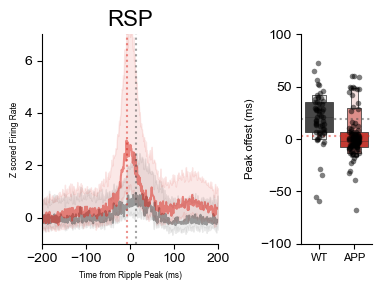

Peak height wilcoxon: -1.1737589334672711, p = 0.24049159726553915
Peak offset wilcoxon: -6.526443497857745, p = 6.734970634836764e-11
Median offset WT = -74
Median offset APP = 5
Median height WT = 4.593549966988885
Median height APP = 5.0618700997876465
sem offset WT = 4.754269875506247
sem offset APP = 2.5868549827010185


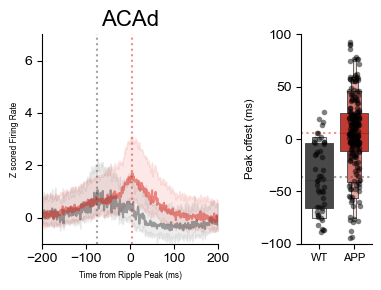

Peak height wilcoxon: -3.978635404594132, p = 6.931193384550344e-05
Peak offset wilcoxon: -0.9377347200721312, p = 0.3483807562269783
Median offset WT = 2
Median offset APP = 2
Median height WT = 4.810358357750357
Median height APP = 6.279470664620581
sem offset WT = 4.912088509418486
sem offset APP = 3.3291425178768534


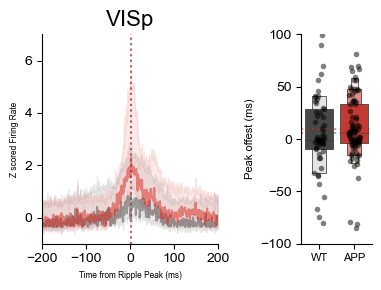

In [26]:
for r,region in enumerate(['RSC','ACC','V1']):


    titles = ['RSP','ACAd','VISp']
    title = titles[r]

    wt_rsu_dat, app_rsu_dat = get_peth_data(ripdir,wt,app,'NREM',region,'RSU')
    wt_rsu_z = zscore_baseline(wt_rsu_dat,binsz=0.001)
    app_rsu_z = zscore_baseline(app_rsu_dat,binsz=0.001)
    wt_rsu_z_sm = dimt.smooth_spikes(wt_rsu_z,binsize=0.001,sigma=0.005)
    app_rsu_z_sm = dimt.smooth_spikes(app_rsu_z,binsize=0.001,sigma=0.005)
    
    
    peaks_wt_rsu = np.max(wt_rsu_z,axis=1)
    peaks_app_rsu = np.max(app_rsu_z,axis=1)
    peakpos_wt_rsu = np.argmax(wt_rsu_z,axis=1)
    peakpos_app_rsu = np.argmax(app_rsu_z,axis=1)

    wtdat = wt_rsu_z
    appdat = app_rsu_z

    # threshcriteria = np.mean(np.hstack([wtdat[:,:200],wtdat[:,-200:]]),axis=1) < np.mean(wtdat[:,950:1050],axis=1)
    threshcriteria =  np.max(wtdat[:,950:1050],axis=1) > 2*np.std(np.hstack([wtdat[:,:100],wtdat[:,-100:]]),axis=1)
    wtdat = wtdat[threshcriteria]
    peakpos_wt_rsu = peakpos_wt_rsu[threshcriteria]
    # threshcriteria = np.mean(np.hstack([appdat[:,:200],appdat[:,-200:]]),axis=1) < np.mean(appdat[:,950:1050],axis=1)
    threshcriteria =  np.max(appdat[:,950:1050],axis=1) > 2*np.std(np.hstack([appdat[:,:100],appdat[:,-100:]]),axis=1)
    appdat = appdat[threshcriteria]
    peakpos_app_rsu = peakpos_app_rsu[threshcriteria]


    peakpos = np.hstack([(peakpos_wt_rsu - 1000),(peakpos_app_rsu - 1000)])
    condlist = np.hstack([np.tile('WT',len(peakpos_wt_rsu)),np.tile('APP',len(peakpos_app_rsu))])
    reglist = np.tile(title,len(peakpos_wt_rsu)+len(peakpos_app_rsu))
    peakdf = pd.DataFrame({'region': reglist, 'genotype': condlist, 'peakpos': peakpos})
    peakdf = peakdf[(peakdf.peakpos > -100) & (peakdf.peakpos < 100)]

    x = np.arange(-200,200)
    
    wtdat2 = wtdat[:,800:1200]
    appdat2 = appdat[:,800:1200]
    
    stdev_wt = np.std(wtdat2,axis=0)/np.sqrt(4)
    stdev_app = np.std(appdat2,axis=0)/np.sqrt(4)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(4,3), gridspec_kw={'width_ratios':[2,0.8]})

    ax[0].plot(x, np.median(wtdat2,axis=0),c=geno_clrs['WT'],alpha=0.5,label='WT')
    ax[0].plot(x, np.median(appdat2,axis=0),c=geno_clrs['APP'],alpha=0.5,label='APP')
    ax[0].fill_between(x, np.mean(wtdat2,axis=0) - stdev_wt, np.mean(wtdat2,axis=0) + stdev_wt,
    color=geno_clrs['WT'],alpha=0.1)
    ax[0].fill_between(x,np.mean(appdat2,axis=0) - stdev_app, np.mean(appdat2,axis=0) + stdev_app,
    color=geno_clrs['APP'],alpha=0.1)
    ax[0].set_xlabel('Time from Ripple Peak (ms)',fontsize=6)
    ax[0].set_ylabel('Z scored Firing Rate',fontsize=6)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[0].set_title(title,fontsize=16)

    ax[0].axvline(np.argmax(np.median(wtdat2,axis=0))-200,c=geno_clrs['WT'],
                  alpha=0.5,linestyle='dotted')
    ax[0].axvline(np.argmax(np.median(appdat2,axis=0))-200,c=geno_clrs['APP'],
                  alpha=0.5,linestyle='dotted')
    ax[0].set_xlim(-200,200)
    ax[0].set_ylim(-1,7)

    sns.boxenplot(ax = ax[1], data = peakdf, x = 'genotype', y = 'peakpos', 
                  showfliers = False, linewidth = 0.5, palette = geno_clrs)
    sns.stripplot(ax = ax[1], data = peakdf, x = 'genotype', dodge = True, y = 'peakpos', 
                  color = 'black', alpha = 0.5, size=4, jitter = 0.15)

    ax[1].axhline(np.mean(peakdf[peakdf.genotype=='WT'].peakpos),color = geno_clrs['WT'],
                  alpha=0.5,linestyle='dotted')
    ax[1].axhline(np.mean(peakdf[peakdf.genotype=='APP'].peakpos),color = geno_clrs['APP'],
                  alpha=0.5,linestyle='dotted')

    ax[1].set_ylim(-100,100)
    ax[1].set_ylabel('Peak offest (ms)', fontsize = 8)
    ax[1].set_xlabel('')
    ax[1].get_xaxis().set_ticklabels(['WT','APP'],fontsize=8)

    pos_stat, pos_p = ranksums(peakdf[peakdf.genotype=='WT'].peakpos,
                               peakdf[peakdf.genotype=='APP'].peakpos)

    print(f'Peak offset wilcoxon: {pos_stat}, p = {pos_p}')
    print("Median offset WT = " + str(np.argmax(np.median(wtdat2,axis=0))-200))
    print("Median offset APP = " + str(np.argmax(np.median(appdat2,axis=0))-200))
    print("sem offset WT = " + str(np.std(peakdf[peakdf.genotype=='WT'].peakpos)/np.sqrt(len(peakdf[peakdf.genotype=='WT']))))
    print("sem offset APP = " + str(np.std(peakdf[peakdf.genotype=='APP'].peakpos)/np.sqrt(len(peakdf[peakdf.genotype=='APP']))))

    sns.despine()
    plt.tight_layout()

    if dump:
        filename = f'swrpeak_by_genotype_{title}.pdf'
        plt.savefig(pth+today+filename)
    else:
        pass

    plt.show()

In [36]:
dump = 1

RSP
Peak height wilcoxon: -3.1488762932639203, p = 0.0016389956057885496
Median height WT = 6.18115245688562
Median height APP = 7.496950291199566
sem height WT = 0.30624086119431904
sem height APP = 0.3814660177996768
ACAd
Peak height wilcoxon: -0.9506890540681798, p = 0.34176224636161345
Median height WT = 5.516709796352783
Median height APP = 5.615110029518723
sem height WT = 0.2062600784531782
sem height APP = 0.27523046485946334
VISp
Peak height wilcoxon: -2.0121474077088366, p = 0.044204400512425565
Median height WT = 6.601302829364611
Median height APP = 7.594376617802
sem height WT = 0.38539278450343406
sem height APP = 0.4302206635321054


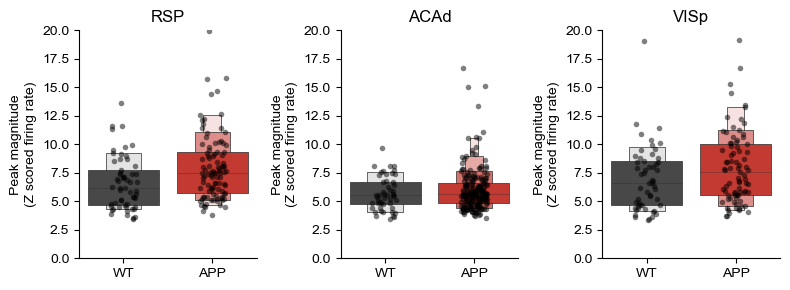

In [38]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(8,3))

for r,region in enumerate(['RSC','ACC','V1']):


    titles = ['RSP','ACAd','VISp']
    title = titles[r]

    wt_rsu_dat, app_rsu_dat = get_peth_data(ripdir,wt,app,'NREM',region,'RSU')
    wt_rsu_z = zscore_baseline(wt_rsu_dat,binsz=0.001)
    app_rsu_z = zscore_baseline(app_rsu_dat,binsz=0.001)
    
    peaks_wt_rsu = np.max(wt_rsu_z,axis=1)
    peaks_app_rsu = np.max(app_rsu_z,axis=1)
    peakpos_wt_rsu = np.argmax(wt_rsu_z,axis=1)
    peakpos_app_rsu = np.argmax(app_rsu_z,axis=1)

    wtdat = wt_rsu_z
    appdat = app_rsu_z

    # threshcriteria = np.mean(np.hstack([wtdat[:,:200],wtdat[:,-200:]]),axis=1) < np.mean(wtdat[:,950:1050],axis=1)
    threshcriteria =  np.max(wtdat[:,950:1050],axis=1) > 2*np.std(np.hstack([wtdat[:,:100],wtdat[:,-100:]]),axis=1)
    wtdat = wtdat[threshcriteria]
    peakpos_wt_rsu = peakpos_wt_rsu[threshcriteria]
    peaks_wt_rsu = peaks_wt_rsu[threshcriteria]
    # threshcriteria = np.mean(np.hstack([appdat[:,:200],appdat[:,-200:]]),axis=1) < np.mean(appdat[:,950:1050],axis=1)
    threshcriteria =  np.max(appdat[:,950:1050],axis=1) > 2*np.std(np.hstack([appdat[:,:100],appdat[:,-100:]]),axis=1)
    appdat = appdat[threshcriteria]
    peakpos_app_rsu = peakpos_app_rsu[threshcriteria]
    peaks_app_rsu = peaks_app_rsu[threshcriteria]


    peakpos = np.hstack([(peakpos_wt_rsu - 1000),(peakpos_app_rsu - 1000)])
    peaks = np.hstack([peaks_wt_rsu, peaks_app_rsu])
    condlist = np.hstack([np.tile('WT',len(peakpos_wt_rsu)),np.tile('APP',len(peaks_app_rsu))])
    reglist = np.tile(title,len(peaks_wt_rsu)+len(peakpos_app_rsu))
    peakdf = pd.DataFrame({'region': reglist, 'genotype': condlist, 'peakpos': peakpos})
    magdf = pd.DataFrame({'region': reglist, 'genotype': condlist, 'peakheight': peaks})
    magdf = magdf[(peakdf.peakpos > -100) & (peakdf.peakpos < 100)]
    magdf = magdf[magdf.peakheight < 20]
    
    sns.boxenplot(ax = ax[r], data = magdf, x = 'genotype', y = 'peakheight', 
                  showfliers = False, linewidth = 0.5, palette = geno_clrs)
    sns.stripplot(ax = ax[r], data = magdf, x = 'genotype', dodge = True, y = 'peakheight', 
                  color = 'black', alpha = 0.5, size=4, jitter = 0.15)

    ax[r].set_ylim(0,20)
    ax[r].set_ylabel('Peak magnitude\n(Z scored firing rate)', fontsize = 10)
    ax[r].set_xlabel('')
    ax[r].get_xaxis().set_ticklabels(['WT','APP'],fontsize=10)
    ax[r].set_title(title)

    peak_stat, peak_p = ranksums(magdf[magdf.genotype=='WT'].peakheight,
                               magdf[magdf.genotype=='APP'].peakheight)

    print(title)
    print(f'Peak height wilcoxon: {peak_stat}, p = {peak_p}')
    print("Median height WT = " + str(np.median(magdf[magdf.genotype=='WT'].peakheight)))
    print("Median height APP = " + str(np.median(magdf[magdf.genotype=='APP'].peakheight)))
    print("sem height WT = " + str(np.std(magdf[magdf.genotype=='WT'].peakheight)/np.sqrt(len(magdf[magdf.genotype=='WT']))))
    print("sem height APP = " + str(np.std(magdf[magdf.genotype=='APP'].peakheight)/np.sqrt(len(magdf[magdf.genotype=='WT']))))

    sns.despine()
plt.tight_layout()

if dump:
    filename = f'swrpeakmag_by_genotype.pdf'
    plt.savefig(pth+today+filename)
else:
    pass

plt.show()